In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init
from torch.autograd import grad

from scipy.integrate import solve_ivp

from utils import FeedForwardNetwork, plot_ode, plot_losses, rmse

In [2]:
class LotkaVolterra:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.alpha, self.beta, self.delta, self.gamma = params
        self.init_vals = torch.tensor(initial_conditions)

        self.t = torch.linspace(0, self.T, 128)
        self.solution = self._solve()
    
    def loss_initial(self, model):
        zero = torch.tensor([0.], requires_grad=True)
        x = model(zero)
        return torch.mean(torch.square(x - self.init_vals))
    
    def loss_physical(self, model, t):
        xy = model(t)
        x = xy[:,[0]]
        y = xy[:,[1]]

        dX = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        dY = grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        loss_dX = torch.mean(torch.square(dX - self.alpha * x + self.beta * x * y))
        loss_dY = torch.mean(torch.square(dY - self.delta * x * y + self.gamma * y))
        
        return loss_dX, loss_dY
    
    def _solve(self):
        def lotka_volterra(t, y, alpha, beta, delta, gamma):
            x, y = y
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

        solution = solve_ivp(lotka_volterra, 
                             (0, self.T),
                             self.init_vals, 
                             method='RK45',
                             args=(self.alpha, self.beta, self.delta, self.gamma), 
                             t_eval=self.t.numpy())
        
        return solution.y

In [3]:
def train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000, save_every=1000
):
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = rmse(x, problem.solution[0])
            error_y = rmse(y, problem.solution[1])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(np.array([error_x, error_y]))
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {error_x}, {error_y}')
    
    return np.array(losses), np.array(errors)

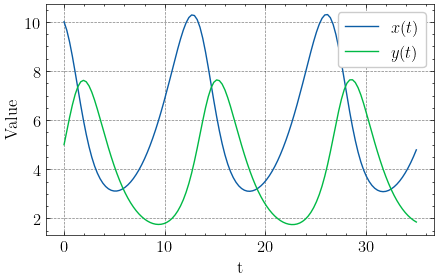

In [5]:
T = 35
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])

plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$'), ((problem.solution[1], r'$y(t)$'))], size=(5, 3))

In [11]:
L, W = 4, 64
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2)
model.init_weights(init.zeros_)

w1, w2, w3 = 1, 2, 2
num_iters = 10000
N_D = 3072
lr = 1e-2
collect_every = 500

losses, errors = train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=2500
)

Iteration 0 --- 6.205256720376631, 4.592316068329934
Iteration 2500 --- 3.6508006847968413, 2.066891164613714
Iteration 5000 --- 3.6491862395176873, 2.0672645432275543
Iteration 7500 --- 3.6541359982784685, 2.0664665804591507
Iteration 10000 --- 3.650749804919775, 2.066886309077989


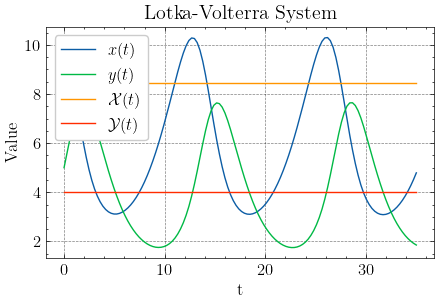

In [12]:
preds = model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$'), (problem.solution[1], r'$y(t)$')],
    predicted=[(x, r'$\mathcal{X}(t)$'), (y, r'$\mathcal{Y}(t)$')],
    title='Lotka-Volterra System', size=(5, 3)
)

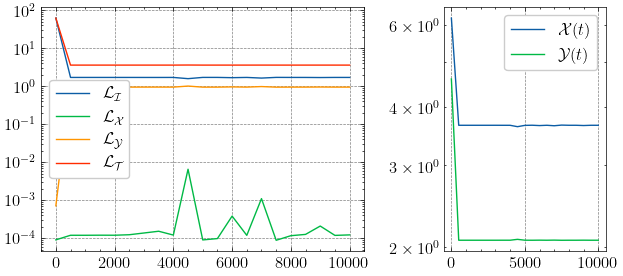

In [13]:
plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_X}$'),
        (losses[:,2], r'$\mathcal{L_Y}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors[:,0], r'$\mathcal{X}(t)$'),
        (errors[:,1], r'$\mathcal{Y}(t)$')
    ]
)